# Notebook For Monte Carlo Project
#### Written as a requirement for Degree Probability and Finance at Ecole Polytechnique and Sorbonne University
### Author : Oussama Elghodhben


This notebook will contain a general structure for Multilevel Monte Carlo problems described in Giles (2015) "Multilevel Monte Carlo Methods" and a different class implementation for each individual problem that implements a function which defines the fine and coarse path approximation for a given level. In other words, applying the method to different problem only requires the definition of the problem class that implements the evalute function which returns the fine and coarse approximations. The rest of the code would stay the same.

## The Multilevel Structure (problem independent implementation)

Note that In this section we are using the adaptive algorithm described in Giles(2008) and slightly improved in Giles(2015). This implementation serves for evaluating the Multilevel estimator independtly and does not serve for comparaison with ML2R

In [270]:
import numpy
import numpy.linalg
import timeit
from datetime import datetime
import numpy
from math import sqrt
import sys
from scipy.stats import linregress
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import pandas as pd

In [252]:
def mlmc(N0, eps, mlmc_fn, alpha_0, beta_0, gamma_0, problem,  *args, **kwargs):
    theta = 0.25
    L = 2
    Nl = np.zeros(L)
    S = np.zeros((2, L))
    C = np.zeros(L)
    dNl = N0 * np.ones(L)

    while sum(dNl) > 0:
        for l in range(0, L):
            if dNl[l] > 0:
                sums, cost = mlmc_fn(l, int(dNl[l]), problem, *args, **kwargs)
                Nl[l] += dNl[l]
                S[0, l] += sums[0]
                S[1, l] += sums[1]
                C[l] += cost

        mean = np.abs(S[0, :] / Nl)
        var = np.maximum(0, S[1, :] / Nl - mean ** 2)
        cost_per_level = C / Nl

        for l in range(3, L + 1):
            mean[l - 1] = max(mean[l - 1], 0.5 * mean[l - 2] / 2 ** alpha)
            var[l - 1] = max(var[l - 1], 0.5 * var[l - 2] / 2 ** beta)

        if alpha_0 <= 0:
            A = np.ones((L - 1, 2))
            A[:, 0] = range(1, L)
            x = np.linalg.lstsq(A, np.log2(mean))[0]
            alpha = max(0.5, -x[0])
        else :
            alpha = alpha_0

        if beta_0 <= 0:
            A = np.ones((L - 1, 2))
            A[:, 0] = range(1, L)
            x = np.linalg.lstsq(A, np.log2(var))[0]
            beta = max(0.5, -x[0])
        else :
            beta = beta_0

        if gamma_0 <= 0:
            A = np.ones((L - 1, 2))
            A[:, 0] = range(1, L)
            x = np.linalg.lstsq(A, np.log2(cost_per_level))[0]
            gamma = max(0.5, x[0])
        else :
            gamma = gamma_0

        optimal_samples = np.ceil(np.sqrt(var / cost_per_level) * sum(np.sqrt(var * cost_per_level))
                                  / ((1 - theta) * eps ** 2))
        dNl = np.maximum(0, optimal_samples - Nl)

        if sum(dNl > 0.01 * Nl) == 0:
            remaining_error = mean[-1] / (2 ** alpha - 1.0)
            if remaining_error > np.sqrt(theta) * eps:
                L += 1
                Nl = np.append(Nl, 0.0)
                S = np.column_stack([S, [0, 0]])
                C = np.append(C, C[-1] * 2 ** gamma)
                dNl = np.append(dNl, N0)

    P = sum(S[0, :] / Nl)

    return P, Nl, cost_per_level

In [253]:
def eval_fn(l, N, problem, *args, **kwargs):
    problems = {'GBM': GBM}
    pb = problems[problem](*args, **kwargs)
    return pb.eval_Y(l, N)

In [254]:
def mlmc_test(fn, problem, N, L, N0, l_eps, *args, **kwargs):
    
    results = {'mean_y': [], 'mean_p': [], 'var_y': [], 'var_p': [] , 'kurt': [], 'test': [], 'cost': []}

    for l in tqdm(range(0, L+1)):

        (res, cst) = fn(l, N, problem, *args, **kwargs)
        cst = cst/N
        res = res/N

        if l == 0:
            kurt = 0.0
        else:
            kurt = (     res[3]
                     - 4*res[2]*res[0]
                     + 6*res[1]*res[0]**2
                     - 3*res[0]*res[0]**3 ) / (res[1]-res[0]**2)**2

        results['cost'].append(cst)
        results['mean_y'].append(res[0])
        results['mean_p'].append(res[4])
        results['var_y'].append(res[1]-res[0]**2)
        results['var_p'].append(max(res[5]-res[4]**2, 1.0e-10)) # fix for cases with var = 0
        results['kurt'].append(kurt)

        if l == 0:
            t = 0
        else:
            t =          abs(       results['mean_y'][l]  +      results['mean_p'][l-1]  -      results['mean_p'][l])
            t = t / ( 3.0*(numpy.sqrt(results['var_y'][l]) + numpy.sqrt(results['var_p'][l-1]) + numpy.sqrt(results['var_p'][l]) )/numpy.sqrt(N))
        results['test'].append(t)

    # linear regression to estimate alpha, beta and gamma
    L1 = 1
    L2 = L+1
    levels = range(L1+1, L2+1)
    alpha = max(0.5, -linregress(levels, numpy.log2(numpy.abs(results['mean_y'][L1:L2]))).slope)

    beta = max(0.5, -linregress(levels, numpy.log2(numpy.abs(results['var_y'][L1:L2]))).slope)

    gamma = linregress(levels, numpy.log2(numpy.abs(results['cost'][L1:L2]))).slope

    print(alpha, beta, gamma)
    theta = 0.25
    l_cost = []
    mc_cost = []
    Ns = []
    ls = []
    for eps in tqdm(l_eps):
        (P, Nl, Cl) = mlmc(N0, eps, fn, alpha, beta, gamma, problem, *args, **kwargs)
        Ns.append(Nl)
        ls.append(range(len(Nl)))
        l = len(Nl) - 1
        l_cost.append(numpy.dot(Nl,Cl))
        mc_cost.append(results['var_p'][-1]*Cl[l]/((1.0 -theta)*eps**2))
    return results, np.array(l_cost), np.array(mc_cost), np.array(ls, dtype = 'object'), np.array(Ns, dtype = 'object')

In [255]:
def mlmc_plot(l_eps, results, mc_cost, std_cost, ls , Ns):
    """
    Generate MLMC diagnostic plots based on results returned by mlmc_test.

    Inputs:
      results: dictionary containing the results returned by mlmc_test
      mc_cost: cost per sample computed from MLMC complexity tests
      std_cost: standard Monte Carlo cost per sample
      error_bars: flag to add error bars in plots of level differences

    Outputs:
      Matplotlib figure(s) showing various MLMC diagnostic plots
    """

    width = 10
    height = 18
    plt.figure(figsize=([width, height]))

    # Var[P_l - P_{l-1}] per level
    plt.subplot(3, 2, 1)
    plt.plot(range(len(results['mean_y'])), np.log2(results['var_p']), label=r'$P_\ell$')
    plt.plot(range(1, len(results['mean_y'])), np.log2(results['var_y'][1:]), label=r'$P_\ell - P_{\ell-1}$')
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\mathrm{log}_2(\mathrm{variance})$')
    plt.legend(loc='lower left', fontsize='medium')
    plt.title('Var[P_l - P_{l-1}] per level')

    # E[|P_l - P_{l-1}|] per level
    plt.subplot(3, 2, 2)
    plt.plot(range(len(results['mean_y'])), np.log2(np.abs(results['mean_p'])), label=r'$P_\ell$')
    plt.plot(range(1, len(results['mean_y'])), np.log2(np.abs(results['mean_y'][1:])), label=r'$P_\ell - P_{\ell-1}$')
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\mathrm{log}_2(|\mathrm{mean}|)$')
    plt.legend(loc='lower left', fontsize='medium')
    plt.title('E[|P_l - P_{l-1}|] per level')

    # cost per level
    plt.subplot(3, 2, 3)
    plt.plot(range(len(results['cost'])), np.log2(results['cost']), '*--')
    plt.xlabel('level $\ell$')
    plt.ylabel(r'$\log_2$ cost per sample')
    plt.title('Cost per level')

    # kurtosis per level
    plt.subplot(3, 2, 4)
    plt.plot(range(1, len(results['kurt'])), results['kurt'][1:], '*--')
    plt.xlabel('level $\ell$')
    plt.ylabel('kurtosis')
    plt.title('Kurtosis per level')

    # number of samples per level
    plt.subplot(3, 2, 5)
    for (eps, ll, n) in zip(l_eps, ls, Ns):
        plt.semilogy(ll, n, label=eps, markerfacecolor='none', clip_on=False)
    plt.xlabel('level $\ell$')
    plt.ylabel('$N_\ell$')
    plt.legend(loc='upper right', frameon=True, fontsize='medium')
    plt.title('Number of Samples per Level')

    # Normalized cost for given accuracy
    eps = np.array(l_eps)
    I = np.argsort(eps)
    plt.subplot(3, 2, 6)
    plt.loglog(eps[I], eps[I]**2 * std_cost[I],  '*-',  label='Std MC', clip_on=False)
    plt.loglog(eps[I], eps[I]**2 * mc_cost[I], '*--', label='MLMC',   clip_on=False)
    plt.xlabel(r'accuracy $\varepsilon$')
    plt.ylabel(r'$\varepsilon^2$ cost')
    plt.legend(fontsize='medium')
    plt.title('Normalized Cost for Given Accuracy')

    plt.show()


# Problem definitions

In [256]:
class GBM :
    def __init__(self, S0, r, q, sigma, T, K):
        self.S0 = S0
        self.r = r
        self.q = q
        self.sigma = sigma
        self.T = T
        self.K = K
    def eu_call(self, X):
        return np.exp(-self.r * self.T) * np.maximum(0, X - self.K)
    def digital_call(self, X):
        return np.exp(-self.r * self.T) * np.heaviside(X - self.K, 0)
    def eval_Y(self, l, N):
        N = int(N)
        nf = self.T * 2**l
        nc = nf/2
        dtf = self.T/nf
        dtc = self.T/nc
        
        l_y = np.zeros(6)
        
        Xf = self.S0 * np.ones(N)
        Xc = self.S0 * np.ones(N)
        start = time.perf_counter()
        if l == 0 :
            dWf = np.sqrt(dtf)* np.random.randn(N)
            Xf += self.r * Xf * dtf + self.sigma * Xf * dWf
        else :
            for i in range(int(nc)):
                dWc = np.zeros(N)
                for j in range(2):
                    dWf = np.sqrt(dtf) * np.random.randn(N)
                    dWc += dWf
                    Xf += self.r * Xf * dtf + self.sigma * Xf * dWf
                Xc += self.r * Xc * dtc + self.sigma * Xc * dWc
        Pf = self.eu_call(Xf)
        if l == 0 :
            Pc = 0
        else :
            Pc = self.eu_call(Xc)
        l_y = np.array([np.sum(Pf - Pc), np.sum((Pf - Pc)**2), np.sum((Pf - Pc)**3), np.sum((Pf - Pc)**4), np.sum(Pf), np.sum((Pf)**2)])
        end = time.perf_counter()
        cost = end - start
        return l_y, cost

# Testing

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 70.23it/s]


0.9676669095564517 0.9667199255009867 0.83662370706892


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.40it/s]


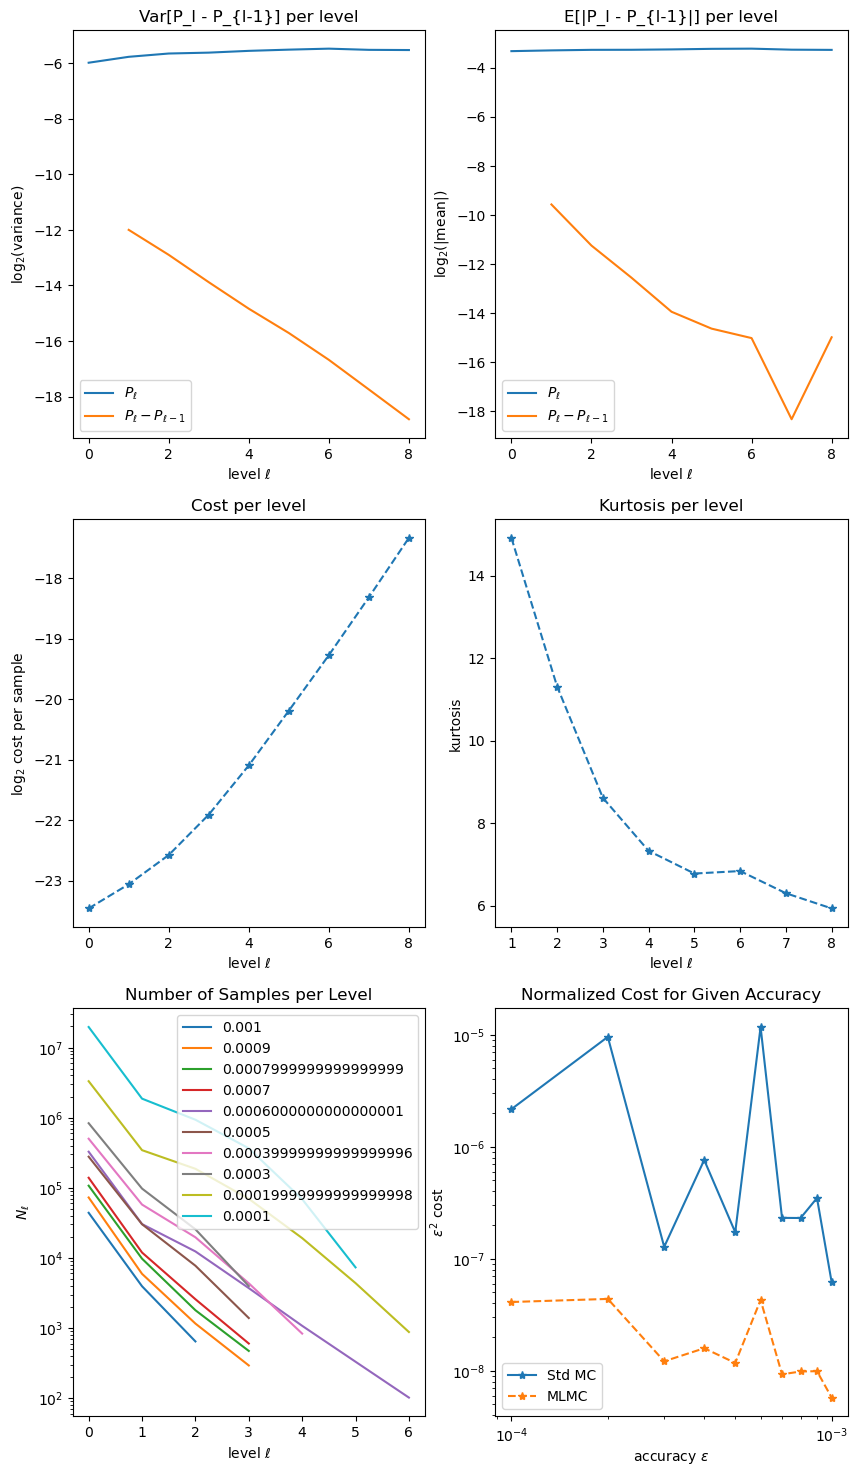

In [257]:
T = 1
K = 1
S0 = 1
r = 0.05
q = 0
sigma = 0.2
problem = 'GBM'
N = 1e4
N0 = 1e2
L = 8
l_eps = np.flip(np.linspace(0.0001, 0.001, 10))

results, mlmc_cost, mc_cost, ls, Ns = mlmc_test(eval_fn, problem, N, L, N0, l_eps, S0, r, q, sigma, T, K)
mlmc_plot(l_eps, results, mlmc_cost, mc_cost, ls, Ns)

These results confirm the theoritical findings in Giles 2008 resumed in the MLMC complexity theorem. We see the sligh increase of the complexiy with finer errors is due to the $log(\epsilon)^2$ in the case of $\beta = \gamma$

# ML2R and MLMC non Adaptive Implementation

## ML2R Implementation

We again opt for a problem Independent Structure and implement each problem inside it's own class

In [384]:
def R_eps(eps, c, H, M, alpha):
    A = np.sqrt(1 + 4 * alpha)
    return np.ceil(0.5 + np.log(c**(1/alpha)*H)/np.log(M) + sqrt((0.5 + np.log(c**(1/alpha)*H)/np.log(M))**2 + 2 * np.log(A/eps)/(alpha * np.log(M))))

In [385]:
def h_eps(eps, alpha, R, c, H, M):
    return H/np.ceil((1 + 2 * alpha * R)**(-1/(2*alpha*R)) * eps**(1/(alpha*R)) * c**(-1/alpha) * M**((R-1)/2)*H)

In [386]:
def gen_w(alpha, M, R):
    w = np.zeros(R)
    for i in range(R):
        w[i] = ((-1)**(R-i-1) * M**(-0.5 * alpha * (R - i -1)*(R - i)))/(np.prod(np.array([(1 - M**(-alpha * j)) for j in range(1, i+1)])) * np.prod(np.array([(1 - M**(-alpha * j)) for j in range(1, R-i)])))
    return w

In [387]:
def W_f(alpha, M, R):
    w = gen_w(alpha, M, R)
    W = np.zeros(R)
    for j in range(R):
        W[j] = np.sum(w[j:])
    return W

In [388]:
def q_eps(theta, h, alpha, beta, R, M):
    W = W_f(alpha, M, R)
    q = np.zeros(R)
    q[0] = (1 + theta * h ** (beta/2))
    for j in range(1, R):
        q[j] = theta * h**(beta/2)*(np.abs(W[j]) * (M**(-beta * (j - 1)/2) + M**(-beta * j/2))/np.sqrt(M**(j - 1) + M**(j)))
    mu_R = 1 / np.sum(q)
    q = mu_R*q
    return q, mu_R

In [389]:
def N_eps(eps, alpha, beta, theta, V0, M, R, h, q, mu_R, W):
    return (1 + 1/(2 * alpha * R)) * V0 * (1 + theta * h**(beta/2) * np.sum(np.array([np.abs(W[j]) * (M**(-beta * (j - 1)/2) + M**(-beta * j/2)) * np.sqrt(M**(j - 1) + M**(j)) for j in range(R)])))/(eps**2 * mu_R)

In [424]:
def ML2R_estimator(pb, payoff, scheme, eps, alpha, beta, V0, theta, c, H, M, L):
    R = int(R_eps(eps, c, H, M, alpha))
    h = h_eps(eps, alpha, R, c, H, M)
    q, mu_R = q_eps(theta, h, alpha, beta, R, M)
    W = W_f(alpha, M, R)
    N = N_eps(eps, alpha, beta, theta, V0, M, R, h, q, mu_R, W)
    price = 0
    cost = 0
    for l in range(R):
        Nl = int(np.ceil(q[l] * N))
        l_y, cst = pb.eval_Y(payoff, scheme, l, Nl, h, M)
        price += W[l] * l_y[0]/Nl 
        cost += cst
    return price, cst, R, N, h

## MLMC Implementation

In [344]:
def R_eps_mlmc(eps, c, H, M, alpha):
    A = np.sqrt(1 + 4 * alpha)
    return np.ceil(1 + np.log(c**(1/alpha)*H)/np.log(M) + np.log(A/eps)/(alpha * np.log(M)))

In [345]:
def h_eps_mlmc(eps, alpha, R, c, H, M):
    return H/np.ceil((1 + 2 * alpha)**(-1/(2*alpha)) * eps**(1/(alpha)) * c**(-1/alpha) * M**((R-1))*H)

In [346]:
def q_eps_mlmc(theta, h, alpha, beta, R, M):
    W = W_f(alpha, M, R)
    q = np.zeros(R)
    q[0] = (1 + theta * h ** (beta/2))
    for j in range(1, R):
        q[j] = theta * h**(beta/2)*((M**(-beta * (j - 1)/2) + M**(-beta * j/2))/np.sqrt(M**(j - 1) + M**(j)))
    mu_R = 1 / np.sum(q)
    q = mu_R*q
    return q, mu_R

In [347]:
def N_eps_mlmc(eps, alpha, beta, theta, V0, M, R, h, q, mu_R, W):
    return (1 + 1/(2 * alpha)) * V0 * (1 + theta * h**(beta/2) * np.sum(np.array([(M**(-beta * (j - 1)/2) + M**(-beta * j/2)) * np.sqrt(M**(j - 1) + M**(j)) for j in range(R)])))/(eps**2 * mu_R)

In [425]:
def MLMC_estimator(pb, payoff, scheme, eps, alpha, beta, V0, theta, c, H, M, L):
    R = int(R_eps_mlmc(eps, c, H, M, alpha))
    h = h_eps_mlmc(eps, alpha, R, c, H, M)
    q, mu_R = q_eps_mlmc(theta, h, alpha, beta, R, M)
    W = W_f(alpha, M, R)
    N = N_eps_mlmc(eps, alpha, beta, theta, V0, M, R, h, q, mu_R, W) 
    price = 0
    cost = 0
    for l in range(R):
        Nl = int(np.ceil(q[l] * N))
        l_y, cst = pb.eval_Y(payoff, scheme, l, Nl, h, M)
        price += l_y[0]/Nl 
        cost += cst
    return price, cst, R, N, h

## Problem definitions

In [426]:
def estimate_params(pb, payoff, scheme, L, h, M, N):
    results = {'mean_y': [], 'mean_p': [], 'var_y': [], 'var_p': [], 'cost': []}

    for l in tqdm(range(0, L+1)):

        (res, cst) = pb.eval_Y(payoff, scheme, l, N, h, M)
        cst = cst/N
        res = res/N

        results['cost'].append(cst)
        results['mean_y'].append(res[0])
        results['mean_p'].append(res[4])
        results['var_y'].append(res[1]-res[0]**2)
        results['var_p'].append(max(res[5]-res[4]**2, 1.0e-10)) # fix for cases with var = 0

    # linear regression to estimate alpha, beta and gamma
    L1 = 2
    L2 = L+1
    levels = range(L1+1, L2+1)
    alpha = max(0.5, -linregress(levels, numpy.log2(numpy.abs(results['mean_y'][L1:L2]))).slope)

    beta = max(0.5, -linregress(levels, numpy.log2(numpy.abs(results['var_y'][L1:L2]))).slope)

    gamma = linregress(levels, numpy.log2(numpy.abs(results['cost'][L1:L2]))).slope

    V0 = results["var_p"][-1]
    V1 = (1 + M**(-beta/2))**(-2)* h**(-beta)*(results['var_y'][0] + results['mean_y'][0]**2)

    theta = np.sqrt(V1/V0)

    return alpha, beta, gamma, V0, theta

In [535]:
class GBM2 :
    def __init__(self, S0, r, q, sigma, T, K):
        self.S0 = S0
        self.r = r
        self.q = q
        self.sigma = sigma
        self.T = T
        self.K = K
    def eu_call(self, X):
        return np.exp(-self.r * self.T) * np.maximum(0, X - self.K)
    def digital_call(self, X):
        return np.exp(-self.r * self.T) * np.heaviside(X - self.K, 0)
    def eval_Y(self, payoff, scheme, l, N, h, M):
        if payoff == 'eu':
            payoff_func = self.eu_call
        if payoff == 'digital':
            payoff_func = self.digital_call
        
        N = int(N)
        dtf = h * M**(-l)
        dtc = dtf*M
        
        nc = T/dtc
        nf = T/dtf
        
        l_y = np.zeros(6)
        
        Xf = self.S0 * np.ones(N)
        Xc = self.S0 * np.ones(N)
        start = time.perf_counter()
        if l == 0 :
            for i in range(int(nf)):
                dWf = np.sqrt(dtf) * np.random.randn(N)
                if scheme == 'euler':
                    Xf += self.r * Xf * dtf + self.sigma * Xf * dWf
                if scheme == 'milstein':
                    Xf += self.r * Xf * dtf + self.sigma * Xf * dWf + 0.5 * Xf * self.sigma**2 * (dWf**2 - dtf)
        else :
            for i in range(int(nc)):
                dWc = np.zeros(N)
                for j in range(M):
                    dWf = np.sqrt(dtf) * np.random.randn(N)
                    dWc += dWf
                    if scheme == 'euler':
                        Xf += self.r * Xf * dtf + self.sigma * Xf * dWf
                    if scheme == 'milstein':
                        Xf += self.r * Xf * dtf + self.sigma * Xf * dWf + 0.5 * Xf * self.sigma**2 * (dWf**2 - dtf)
                if scheme == 'euler':
                    Xc += self.r * Xc * dtc + self.sigma * Xc * dWc
                if scheme == 'milstein':
                    Xc += self.r * Xc * dtc + self.sigma * Xc * dWc + 0.5 * Xc * self.sigma**2 * (dWc**2 - dtc)
        Pf = payoff_func(Xf)
        if l == 0 :
            Pc = 0
        else :
            Pc = payoff_func(Xc)
        l_y = np.array([np.sum(Pf - Pc), np.sum((Pf - Pc)**2), np.sum((Pf - Pc)**3), np.sum((Pf - Pc)**4), np.sum(Pf), np.sum((Pf)**2)])
        end = time.perf_counter()
        cost = end - start
        return l_y, cost

## Testing zone

<span style="color:red;">The number of trials used to estimate the error was 15 however this could be intensive on some machines. consider lowering the number of test if convergence is too slow</span>


### GBM with Euler Discretization

In [667]:
# GBM parameters
S0 = 100
r = 0.06
q=0
sigma = 0.4
T = 1
K = 80

c = 1
M = 2
H = T
L = 10
eps = 0.5

true_price_eu = 29.4987 #provided by black and sholes formula
l_eps = np.flip(np.linspace(0.1, 0.5, 5))
num_tests = 15

In [628]:
pb = GBM2(S0, r, q, sigma, T, K)

### European Option

In [629]:
scheme = 'euler'
payoff = 'eu'

In [653]:
alpha, beta, gamma , V0, theta = estimate_params(pb, payoff, scheme, L, 1, M, int(1e5))
print(alpha, beta, gamma , V0, theta)
alpha = 1
beta = 1
#V0 = 860
#theta = 0.25

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.50it/s]

0.9895395015851003 1.9347213712909483 0.8577492360068851 1350.2601308122669 0.8129556953416377


In [654]:
results_ML2R = np.zeros((len(l_eps), 6))
results_MLMC = np.zeros((len(l_eps), 6))
for j in tqdm(range(len(l_eps))):
    error_ML2R = 0
    error_MLMC = 0
    cost_ML2R = 0
    cost_MLMC = 0
    for i in tqdm(range(num_tests)):
        price_ML2R, cst_ML2R, R_ML2R, N_ML2R, h_ML2R = ML2R_estimator(pb, payoff, scheme, l_eps[j], alpha, beta, V0, theta, c, H, M, L)
        price_MLMC, cst_MLMC, R_MLMC, N_MLMC, h_MLMC = MLMC_estimator(pb, payoff, scheme, l_eps[j], alpha, beta, V0, theta, c, H, M, L)   
        error_ML2R += (price_ML2R - true_price_eu)**2
        error_MLMC += (price_MLMC - true_price_eu)**2
        cost_ML2R += cst_ML2R
        cost_MLMC += cst_MLMC
    results_ML2R[j, 0] = l_eps[j]
    results_ML2R[j, 1] = error_ML2R/num_tests
    results_ML2R[j, 2] = cost_ML2R/num_tests
    results_ML2R[j, 3] = R_ML2R
    results_ML2R[j, 4] = N_ML2R
    results_ML2R[j, 5] = h_ML2R
    results_MLMC[j, 0] = l_eps[j]
    results_MLMC[j, 1] = error_MLMC/num_tests
    results_MLMC[j, 2] = cost_MLMC/num_tests
    results_MLMC[j, 3] = R_MLMC
    results_MLMC[j, 4] = N_MLMC
    results_MLMC[j, 5] = h_MLMC

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.26s/it]


In [660]:
df_ML2R = pd.DataFrame(results_ML2R, columns = ['eps', 'L2-error', 'time', 'R', 'N', 'h'])
df_MLMC = pd.DataFrame(results_MLMC, columns = ['eps', 'L2-error', 'time', 'R', 'N', 'h'])

In [662]:
df_ML2R

,eps,L2-error,time,R,N,h
0,0.5,0.010633,0.011893,3.0,1.427433e+05,0.5
1,0.4,0.015157,0.021996,3.0,2.230365e+05,0.5
2,0.3,0.000902,0.095277,3.0,6.824838e+05,1.0
3,0.2,0.000866,0.212605,4.0,1.060049e+06,0.5
4,0.1,0.000156,0.992168,4.0,4.240197e+06,0.5


In [663]:
df_MLMC

,eps,L2-error,time,R,N,h
0,0.5,0.002665,0.004681,4.0,1.209533e+05,0.333333
1,0.4,0.012068,0.006967,4.0,2.533562e+05,0.500000
2,0.3,0.003142,0.012293,4.0,4.504110e+05,0.500000
3,0.2,0.003828,0.030952,5.0,1.268356e+06,0.500000
4,0.1,0.000754,0.172246,6.0,6.061598e+06,0.500000


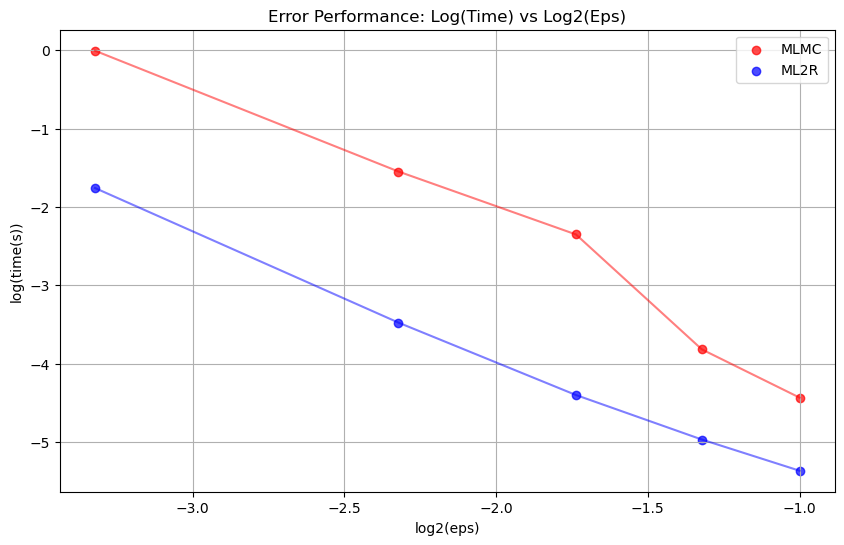

In [665]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log2(df_ML2R['eps']), np.log(df_ML2R['time']), color='red', label='MLMC', alpha=0.7)
plt.plot(np.log2(df_ML2R['eps']), np.log(df_ML2R['time']), color='red', alpha=0.5)
plt.scatter(np.log2(df_MLMC['eps']), np.log(df_MLMC['time']), color='blue', label='ML2R', alpha=0.7)
plt.plot(np.log2(df_MLMC['eps']), np.log(df_MLMC['time']), color='blue', alpha=0.5)
plt.xlabel('log2(eps)')
plt.ylabel('log(time(s))')
plt.title('Error Performance: Log(Time) vs Log2(Eps)')
plt.legend()
plt.grid(True)
plt.show()

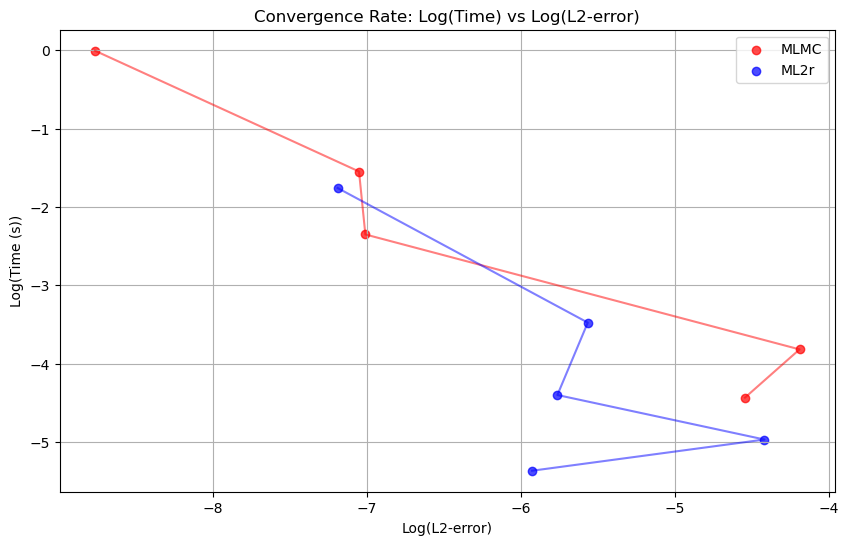

In [666]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(df_ML2R['L2-error']), np.log(df_ML2R['time']), color='red', label='MLMC', alpha=0.7)
plt.plot(np.log(df_ML2R['L2-error']), np.log(df_ML2R['time']), color='red', alpha=0.5)
plt.scatter(np.log(df_MLMC['L2-error']), np.log(df_MLMC['time']), color='blue', label='ML2r', alpha=0.7)
plt.plot(np.log(df_MLMC['L2-error']), np.log(df_MLMC['time']), color='blue', alpha=0.5)
plt.xlabel('Log(L2-error)')
plt.ylabel('Log(Time (s))')
plt.title('Convergence Rate: Log(Time) vs Log(L2-error)')
plt.legend()
plt.grid(True)
plt.show()

### Digital option

In [637]:
scheme = 'euler'
payoff = 'digital'
true_price_digital = 0.653795
l_eps = np.flip(np.linspace(0.1, 0.5, 5))

In [638]:
alpha, beta, gamma , V0, theta = estimate_params(pb, payoff, scheme, L, 1, M, int(1e5))
print(alpha, beta, gamma , V0, theta)
alpha = 0.5
beta = 0.5

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:06<00:00,  1.58it/s]

0.9604986103557498 0.5 0.9458497743952385 0.18825699318155248 1.0160221960004066


In [639]:
results_ML2R = np.zeros((len(l_eps), 6))
results_MLMC = np.zeros((len(l_eps), 6))
for j in tqdm(range(len(l_eps))):
    error_ML2R = 0
    error_MLMC = 0
    cost_ML2R = 0
    cost_MLMC = 0
    for i in range(num_tests):
        price_ML2R, cst_ML2R, R_ML2R, N_ML2R, h_ML2R = ML2R_estimator(pb, payoff, scheme, l_eps[j], alpha, beta, V0, theta, c, H, M, L)
        price_MLMC, cst_MLMC, R_MLMC, N_MLMC, h_MLMC = MLMC_estimator(pb, payoff, scheme, l_eps[j], alpha, beta, V0, theta, c, H, M, L)
        error_ML2R += (price_ML2R - true_price_digital)**2
        error_MLMC += (price_MLMC - true_price_digital)**2
        cost_ML2R += cst_ML2R
        cost_MLMC += cst_MLMC
    results_ML2R[j, 0] = l_eps[j]
    results_ML2R[j, 1] = error_ML2R/num_tests
    results_ML2R[j, 2] = cost_ML2R/num_tests
    results_ML2R[j, 3] = R_ML2R
    results_ML2R[j, 4] = N_ML2R
    results_ML2R[j, 5] = h_ML2R
    results_MLMC[j, 0] = l_eps[j]
    results_MLMC[j, 1] = error_MLMC/num_tests
    results_MLMC[j, 2] = cost_MLMC/num_tests
    results_MLMC[j, 3] = R_MLMC
    results_MLMC[j, 4] = N_MLMC
    results_MLMC[j, 5] = h_MLMC

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 11.49it/s]


In [640]:
df_ML2R = pd.DataFrame(results_ML2R, columns = ['eps', 'L2-error', 'time', 'R', 'N', 'h'])
df_MLMC = pd.DataFrame(results_MLMC, columns = ['eps', 'L2-error', 'time', 'R', 'N', 'h'])

In [641]:
df_ML2R.to_latex(index=False)

\begin{tabular}{rrrrrr}
\toprule
 eps &  L2-error &     time &   R &            N &   h \\
\midrule
 0.5 &  0.031973 & 0.000379 & 4.0 &   690.117665 & 0.5 \\
 0.4 &  0.003773 & 0.000444 & 4.0 &  1078.308852 & 0.5 \\
 0.3 &  0.003001 & 0.000529 & 4.0 &  1916.993514 & 0.5 \\
 0.2 &  0.000261 & 0.002029 & 5.0 &  8392.568533 & 0.5 \\
 0.1 &  0.000664 & 0.006410 & 5.0 & 33570.274134 & 0.5 \\
\bottomrule
\end{tabular}



C:\Users\oussama\AppData\Local\Temp\ipykernel_3436\1629365210.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ML2R.to_latex(index=False))


In [642]:
df_MLMC.to_latex(index=False)

\begin{tabular}{rrrrrr}
\toprule
 eps &  L2-error &     time &    R &           N &        h \\
\midrule
 0.5 &  0.004295 & 0.000531 &  5.0 &  101.613378 & 0.500000 \\
 0.4 &  0.004450 & 0.001309 &  6.0 &  180.181221 & 0.333333 \\
 0.3 &  0.002067 & 0.002382 &  7.0 &  416.465039 & 0.333333 \\
 0.2 &  0.000794 & 0.004754 &  8.0 & 1191.503203 & 0.333333 \\
 0.1 &  0.000103 & 0.019252 & 10.0 & 7387.626164 & 0.333333 \\
\bottomrule
\end{tabular}



C:\Users\oussama\AppData\Local\Temp\ipykernel_3436\2002302611.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_MLMC.to_latex(index=False))


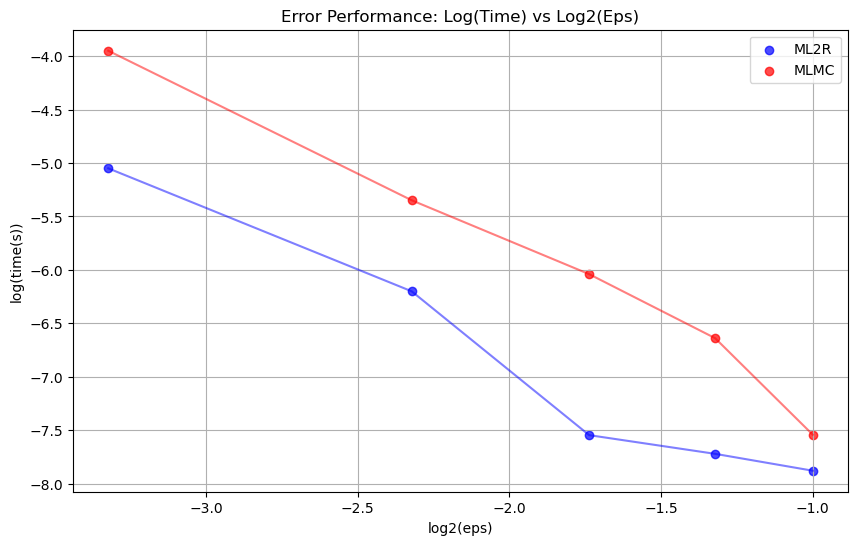

In [643]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log2(df_ML2R['eps']), np.log(df_ML2R['time']), color='blue', label='ML2R', alpha=0.7)
plt.plot(np.log2(df_ML2R['eps']), np.log(df_ML2R['time']), color='blue', alpha=0.5)
plt.scatter(np.log2(df_MLMC['eps']), np.log(df_MLMC['time']), color='red', label='MLMC', alpha=0.7)
plt.plot(np.log2(df_MLMC['eps']), np.log(df_MLMC['time']), color='red', alpha=0.5)
plt.xlabel('log2(eps)')
plt.ylabel('log(time(s))')
plt.title('Error Performance: Log(Time) vs Log2(Eps)')
plt.legend()
plt.grid(True)
plt.show()

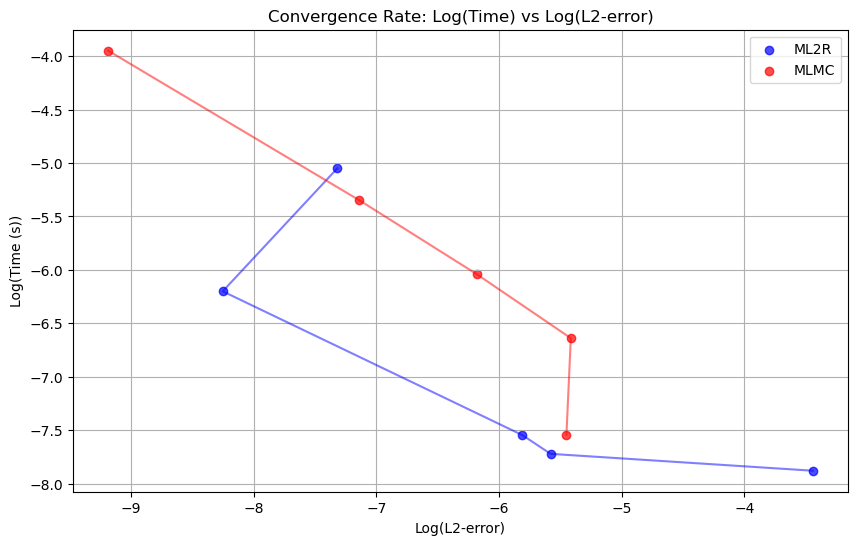

In [644]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(df_ML2R['L2-error']), np.log(df_ML2R['time']), color='blue', label='ML2R', alpha=0.7)
plt.plot(np.log(df_ML2R['L2-error']), np.log(df_ML2R['time']), color='blue', alpha=0.5)
plt.scatter(np.log(df_MLMC['L2-error']), np.log(df_MLMC['time']), color='red', label='MLMC', alpha=0.7)
plt.plot(np.log(df_MLMC['L2-error']), np.log(df_MLMC['time']), color='red', alpha=0.5)
plt.xlabel('Log(L2-error)')
plt.ylabel('Log(Time (s))')
plt.title('Convergence Rate: Log(Time) vs Log(L2-error)')
plt.legend()
plt.grid(True)
plt.show()

### GBM with Milstein Discretization

### European Option

In [645]:
scheme = 'milstein'
payoff = 'eu'

In [646]:
alpha, beta, gamma , V0, theta = estimate_params(pb, payoff, scheme, L, 1, M, int(1e5))
print(alpha, beta, gamma , V0, theta)
alpha = 1
beta = 2
V0 = 860
#theta = 0.25

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:08<00:00,  1.31it/s]

0.991906930366425 1.9360472814680108 0.8957306739619062 1330.1704254062045 0.8235433263226054


In [647]:
results_ML2R = np.zeros((len(l_eps), 6))
results_MLMC = np.zeros((len(l_eps), 6))
for j in tqdm(range(len(l_eps))):
    error_ML2R = 0
    error_MLMC = 0
    cost_ML2R = 0
    cost_MLMC = 0
    for i in range(num_tests):
        price_ML2R, cst_ML2R, R_ML2R, N_ML2R, h_ML2R = ML2R_estimator(pb, payoff, scheme, l_eps[j], alpha, beta, V0, theta, c, H, M, L)
        price_MLMC, cst_MLMC, R_MLMC, N_MLMC, h_MLMC = MLMC_estimator(pb, payoff, scheme, l_eps[j], alpha, beta, V0, theta, c, H, M, L)
        error_ML2R += (price_ML2R - true_price_eu)**2
        error_MLMC += (price_MLMC - true_price_eu)**2
        cost_ML2R += cst_ML2R
        cost_MLMC += cst_MLMC
    results_ML2R[j, 0] = l_eps[j]
    results_ML2R[j, 1] = error_ML2R/num_tests
    results_ML2R[j, 2] = cost_ML2R/num_tests
    results_ML2R[j, 3] = R_ML2R
    results_ML2R[j, 4] = N_ML2R
    results_ML2R[j, 5] = h_ML2R
    results_MLMC[j, 0] = l_eps[j]
    results_MLMC[j, 1] = error_MLMC/num_tests
    results_MLMC[j, 2] = cost_MLMC/num_tests
    results_MLMC[j, 3] = R_MLMC
    results_MLMC[j, 4] = N_MLMC
    results_MLMC[j, 5] = h_MLMC

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


In [648]:
df_ML2R = pd.DataFrame(results_ML2R, columns = ['eps', 'L2-error', 'time', 'R', 'N', 'h'])
df_MLMC = pd.DataFrame(results_MLMC, columns = ['eps', 'L2-error', 'time', 'R', 'N', 'h'])

In [649]:
df_ML2R.to_latex(index=False)

\begin{tabular}{rrrrrr}
\toprule
 eps &  L2-error &     time &   R &            N &   h \\
\midrule
 0.5 &  0.069744 & 0.002085 & 3.0 & 4.178661e+04 & 0.5 \\
 0.4 &  0.027621 & 0.003091 & 3.0 & 6.529159e+04 & 0.5 \\
 0.3 &  0.010464 & 0.015827 & 3.0 & 3.142609e+05 & 1.0 \\
 0.2 &  0.003545 & 0.008635 & 4.0 & 2.644505e+05 & 0.5 \\
 0.1 &  0.001636 & 0.048576 & 4.0 & 1.057802e+06 & 0.5 \\
\bottomrule
\end{tabular}



C:\Users\oussama\AppData\Local\Temp\ipykernel_3436\1629365210.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_ML2R.to_latex(index=False))


In [650]:
df_MLMC.to_latex(index=False)

\begin{tabular}{rrrrrr}
\toprule
 eps &  L2-error &     time &   R &            N &        h \\
\midrule
 0.5 &  0.013696 & 0.000963 & 4.0 & 3.006031e+04 & 0.333333 \\
 0.4 &  0.011172 & 0.001270 & 4.0 & 7.619955e+04 & 0.500000 \\
 0.3 &  0.005907 & 0.001889 & 4.0 & 1.354659e+05 & 0.500000 \\
 0.2 &  0.010593 & 0.003111 & 5.0 & 3.311203e+05 & 0.500000 \\
 0.1 &  0.001352 & 0.008081 & 6.0 & 1.395892e+06 & 0.500000 \\
\bottomrule
\end{tabular}



C:\Users\oussama\AppData\Local\Temp\ipykernel_3436\2002302611.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df_MLMC.to_latex(index=False))


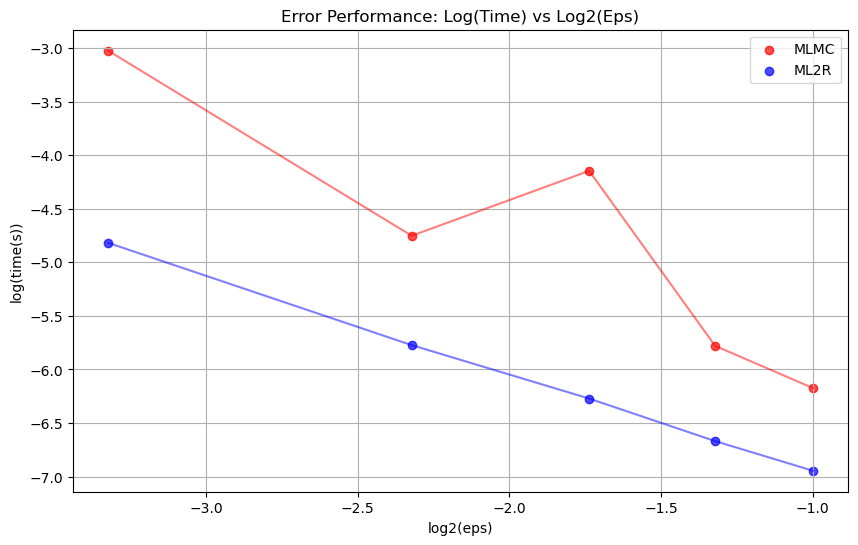

In [651]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log2(df_ML2R['eps']), np.log(df_ML2R['time']), color='red', label='MLMC', alpha=0.7)
plt.plot(np.log2(df_ML2R['eps']), np.log(df_ML2R['time']), color='red', alpha=0.5)
plt.scatter(np.log2(df_MLMC['eps']), np.log(df_MLMC['time']), color='blue', label='ML2R', alpha=0.7)
plt.plot(np.log2(df_MLMC['eps']), np.log(df_MLMC['time']), color='blue', alpha=0.5)
plt.xlabel('log2(eps)')
plt.ylabel('log(time(s))')
plt.title('Error Performance: Log(Time) vs Log2(Eps)')
plt.legend()
plt.grid(True)
plt.show()

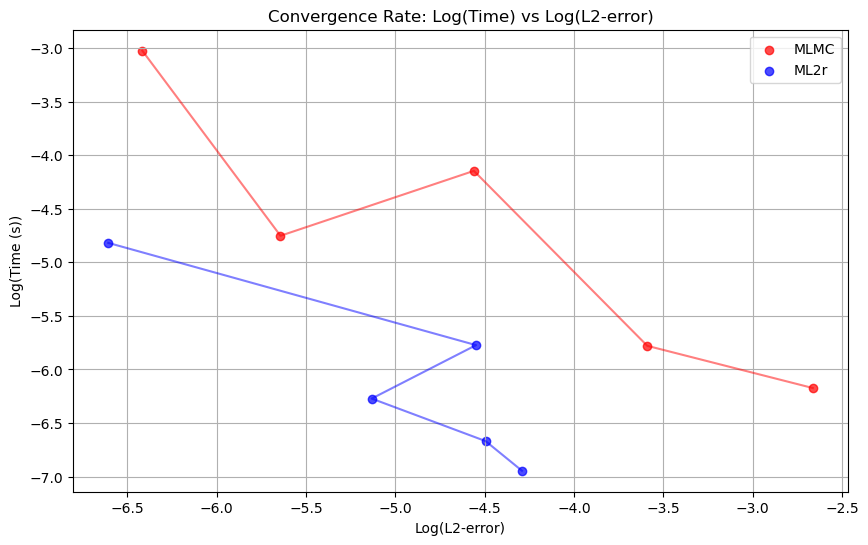

In [652]:
plt.figure(figsize=(10, 6))
plt.scatter(np.log(df_ML2R['L2-error']), np.log(df_ML2R['time']), color='red', label='MLMC', alpha=0.7)
plt.plot(np.log(df_ML2R['L2-error']), np.log(df_ML2R['time']), color='red', alpha=0.5)
plt.scatter(np.log(df_MLMC['L2-error']), np.log(df_MLMC['time']), color='blue', label='ML2r', alpha=0.7)
plt.plot(np.log(df_MLMC['L2-error']), np.log(df_MLMC['time']), color='blue', alpha=0.5)
plt.xlabel('Log(L2-error)')
plt.ylabel('Log(Time (s))')
plt.title('Convergence Rate: Log(Time) vs Log(L2-error)')
plt.legend()
plt.grid(True)
plt.show()